In [13]:
# Environment setup
import sys
from pathlib import Path

# Add src to path
workspace_root = Path.cwd()
while not (workspace_root / 'src').exists() and workspace_root != workspace_root.parent:
    workspace_root = workspace_root.parent

sys.path.insert(0, str(workspace_root / 'src'))

print(f"Project root: {workspace_root}")
print(f"Python version: {sys.version}")
print("✓ Environment configured")

Project root: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment
Python version: 3.12.0 (v3.12.0:0fb18b02c8, Oct  2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]
✓ Environment configured


In [14]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Thesis pipeline utilities
from thesis_pipeline.io.parquet import read_parquet, write_parquet

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All imports successful")

✓ All imports successful


## 1. Load Annotated Dataset

Load the manually annotated stance dataset and validate completeness.

In [15]:
# Paths
stance_path = workspace_root / 'data' / '03_stance' / 'reddit'
topics_path = workspace_root / 'data' / '02_topics' / 'reddit'
model_output_path = stance_path / 'stance_model'
model_output_path.mkdir(parents=True, exist_ok=True)

print(f"Stance data: {stance_path}")
print(f"Topics data: {topics_path}")
print(f"Model output: {model_output_path}")

# Check for annotated dataset
progress_file = stance_path / 'stance_annotation_dataset_progress.parquet'
annotated_file = stance_path / 'stance_annotation_dataset_annotated.parquet'

if annotated_file.exists():
    print(f"\n✓ Found annotated dataset: {annotated_file}")
    annotation_file = annotated_file
elif progress_file.exists():
    print(f"\n✓ Found progress file: {progress_file}")
    annotation_file = progress_file
else:
    raise FileNotFoundError("No annotated dataset found! Expected 'stance_annotation_dataset_progress.parquet' or 'stance_annotation_dataset_annotated.parquet'")

Stance data: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/03_stance/reddit
Topics data: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit
Model output: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/03_stance/reddit/stance_model

✓ Found progress file: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/03_stance/reddit/stance_annotation_dataset_progress.parquet


In [16]:
# Load annotated dataset
print("Loading annotated dataset...")
df_annotated = read_parquet(annotation_file)

print(f"\n✓ Loaded {len(df_annotated):,} annotations")
print(f"\nColumns: {df_annotated.columns.tolist()}")

# Check annotation completeness
annotated_count = df_annotated['stance_label'].notna().sum()
missing_count = df_annotated['stance_label'].isna().sum()

print(f"\nAnnotation status:")
print(f"  Annotated: {annotated_count} ({annotated_count/len(df_annotated)*100:.1f}%)")
print(f"  Missing: {missing_count} ({missing_count/len(df_annotated)*100:.1f}%)")

if missing_count > 0:
    print(f"\n⚠️  Warning: {missing_count} annotations are missing!")
    print("   These will be excluded from training.")

Loading annotated dataset...

✓ Loaded 250 annotations

Columns: ['annotation_id', 'topic_id', 'submission_title', 'submission_selftext', 'parent_body', 'body', 'stance_label', 'annotation_confidence', 'annotation_notes', 'annotator', 'annotation_date', 'comment_id', 'submission_id', 'parent_id', 'subreddit', 'text_length', 'created_utc']

Annotation status:
  Annotated: 250 (100.0%)
  Missing: 0 (0.0%)


In [17]:
# Filter to only annotated examples
df_train_data = df_annotated[df_annotated['stance_label'].notna()].copy()

print(f"Training dataset: {len(df_train_data):,} annotated examples")

# Show label distribution overall
print(f"\nOverall stance distribution:")
print(df_train_data['stance_label'].value_counts())
print(f"\nPercentages:")
print(df_train_data['stance_label'].value_counts(normalize=True) * 100)

# Show distribution per topic
print(f"\nStance distribution per topic:")
for topic_id in df_train_data['topic_id'].unique():
    topic_data = df_train_data[df_train_data['topic_id'] == topic_id]
    print(f"\n{topic_id}:")
    print(topic_data['stance_label'].value_counts())

Training dataset: 250 annotated examples

Overall stance distribution:
stance_label
pro        106
against    101
neutral     43
Name: count, dtype: int64

Percentages:
stance_label
pro        42.4
against    40.4
neutral    17.2
Name: proportion, dtype: float64

Stance distribution per topic:

climate_change:
stance_label
pro        36
against     7
neutral     7
Name: count, dtype: int64

donald_trump:
stance_label
against    28
neutral    12
pro        10
Name: count, dtype: int64

gun_control:
stance_label
against    31
pro        15
neutral     4
Name: count, dtype: int64

immigration:
stance_label
against    23
pro        16
neutral    11
Name: count, dtype: int64

vaccination:
stance_label
pro        29
against    12
neutral     9
Name: count, dtype: int64


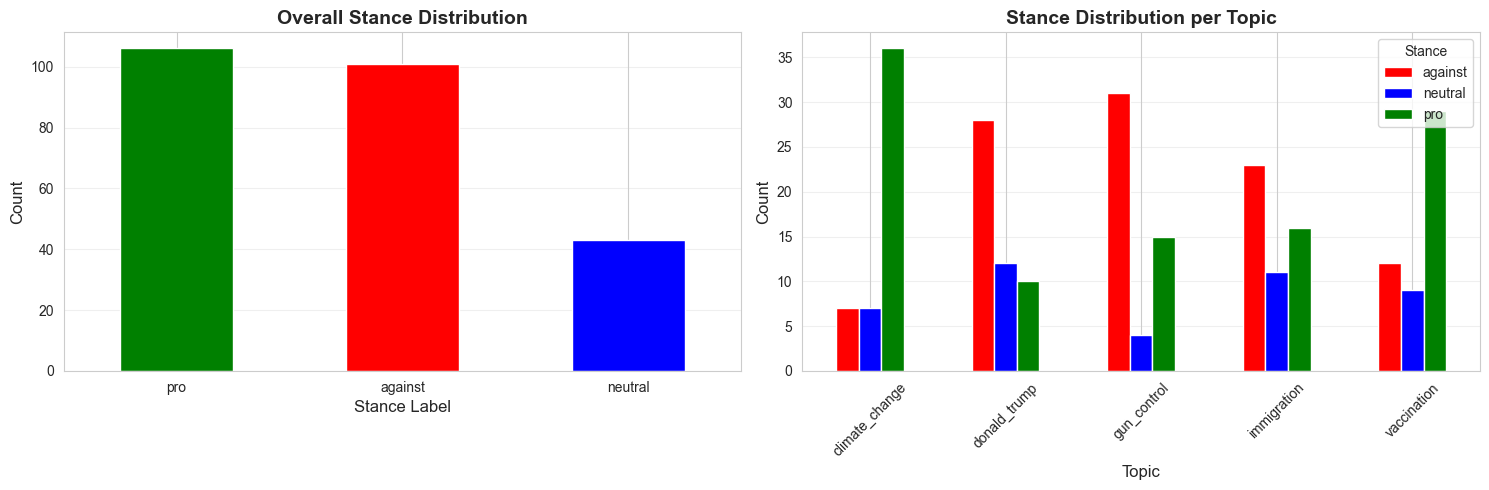

✓ Saved visualization: stance_label_distribution.png


In [18]:
# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall distribution
ax1 = axes[0]
df_train_data['stance_label'].value_counts().plot(kind='bar', ax=ax1, color=['green', 'red', 'blue'])
ax1.set_title('Overall Stance Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Stance Label', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='x', rotation=0)
ax1.grid(axis='y', alpha=0.3)

# Per topic distribution
ax2 = axes[1]
topic_stance_counts = pd.crosstab(df_train_data['topic_id'], df_train_data['stance_label'])
topic_stance_counts.plot(kind='bar', ax=ax2, color=['red', 'blue', 'green'])
ax2.set_title('Stance Distribution per Topic', fontsize=14, fontweight='bold')
ax2.set_xlabel('Topic', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.legend(title='Stance', loc='upper right')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(stance_path / 'stance_label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: stance_label_distribution.png")

## 2. Data Preparation

Prepare text and labels, and split into train/validation/test sets.

In [19]:
# Prepare text and labels
print("Preparing text and labels...")

# For stance detection, we'll use the comment body as the main text
# We could optionally include submission title/body as additional context
df_train_data['text'] = df_train_data['body']

# Encode labels
label_map = {'pro': 0, 'against': 1, 'neutral': 2}
label_names = ['pro', 'against', 'neutral']

df_train_data['label'] = df_train_data['stance_label'].map(label_map)

print(f"\n✓ Prepared {len(df_train_data):,} examples")
print(f"\nLabel encoding:")
for stance, idx in label_map.items():
    count = (df_train_data['label'] == idx).sum()
    print(f"  {idx} = {stance}: {count} examples")

# Check for any missing labels after mapping
if df_train_data['label'].isna().any():
    print(f"\n⚠️  Warning: {df_train_data['label'].isna().sum()} labels could not be mapped!")

Preparing text and labels...

✓ Prepared 250 examples

Label encoding:
  0 = pro: 106 examples
  1 = against: 101 examples
  2 = neutral: 43 examples


In [20]:
# Split into train/validation/test sets
# Strategy: stratify by both topic and label to ensure balanced representation

print("Splitting data into train/val/test sets...")

# Create a combined stratification key
df_train_data['stratify_key'] = df_train_data['topic_id'].astype(str) + '_' + df_train_data['stance_label']

# First split: separate test set (20%)
train_val_df, test_df = train_test_split(
    df_train_data,
    test_size=0.20,
    random_state=42,
    stratify=df_train_data['stratify_key']
)

# Second split: separate validation set (20% of remaining, so 16% of total)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.20,
    random_state=42,
    stratify=train_val_df['stratify_key']
)

print(f"\n✓ Data split complete:")
print(f"  Train: {len(train_df):,} examples ({len(train_df)/len(df_train_data)*100:.1f}%)")
print(f"  Val:   {len(val_df):,} examples ({len(val_df)/len(df_train_data)*100:.1f}%)")
print(f"  Test:  {len(test_df):,} examples ({len(test_df)/len(df_train_data)*100:.1f}%)")

# Verify stratification worked
print(f"\nTrain set distribution:")
print(train_df['stance_label'].value_counts())
print(f"\nValidation set distribution:")
print(val_df['stance_label'].value_counts())
print(f"\nTest set distribution:")
print(test_df['stance_label'].value_counts())

Splitting data into train/val/test sets...

✓ Data split complete:
  Train: 160 examples (64.0%)
  Val:   40 examples (16.0%)
  Test:  50 examples (20.0%)

Train set distribution:
stance_label
pro        68
against    65
neutral    27
Name: count, dtype: int64

Validation set distribution:
stance_label
pro        17
against    16
neutral     7
Name: count, dtype: int64

Test set distribution:
stance_label
pro        21
against    20
neutral     9
Name: count, dtype: int64


## 3. Model Training Setup

Set up the transformer model for stance detection using Hugging Face transformers.

In [21]:
# Check if transformers is installed
try:
    import transformers
    print(f"✓ Transformers version: {transformers.__version__}")
except ImportError:
    print("⚠️  Transformers not installed. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "transformers[torch]", "datasets", "accelerate"])
    print("✓ Transformers installed")

✓ Transformers version: 4.57.2


In [22]:
# Import transformers libraries
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
import torch

print(f"✓ Transformers imports successful")
print(f"PyTorch version: {torch.__version__}")

✓ Transformers imports successful
PyTorch version: 2.9.0


In [23]:
# Define candidate models to test
CANDIDATE_MODELS = {
    'distilbert-base-uncased': {
        'name': 'DistilBERT',
        'description': 'Fast, lightweight, 66M parameters',
        'expected_speed': 'Fast'
    },
    'roberta-base': {
        'name': 'RoBERTa Base',
        'description': 'Strong performance, 125M parameters',
        'expected_speed': 'Medium'
    },
    'bert-base-uncased': {
        'name': 'BERT Base',
        'description': 'Classic baseline, 110M parameters',
        'expected_speed': 'Medium'
    },
    'microsoft/deberta-v3-small': {
        'name': 'DeBERTa-v3 Small',
        'description': 'Efficient DeBERTa variant, 44M parameters',
        'expected_speed': 'Fast'
    }
}

print("Candidate models for testing:")
for model_id, info in CANDIDATE_MODELS.items():
    print(f"\n{info['name']} ({model_id})")
    print(f"  {info['description']}")
    print(f"  Expected speed: {info['expected_speed']}")

Candidate models for testing:

DistilBERT (distilbert-base-uncased)
  Fast, lightweight, 66M parameters
  Expected speed: Fast

RoBERTa Base (roberta-base)
  Strong performance, 125M parameters
  Expected speed: Medium

BERT Base (bert-base-uncased)
  Classic baseline, 110M parameters
  Expected speed: Medium

DeBERTa-v3 Small (microsoft/deberta-v3-small)
  Efficient DeBERTa variant, 44M parameters
  Expected speed: Fast


In [24]:
# Function to train and evaluate a model
def train_and_evaluate_model(model_name, train_dataset, val_dataset, test_dataset, num_epochs=2):
    """
    Train a model and return evaluation metrics and timing info.
    Using fewer epochs (2) for quick comparison.
    """
    print(f"\n{'='*80}")
    print(f"Testing: {CANDIDATE_MODELS[model_name]['name']} ({model_name})")
    print(f"{'='*80}\n")
    
    results = {
        'model_name': model_name,
        'display_name': CANDIDATE_MODELS[model_name]['name']
    }
    
    try:
        # Load tokenizer and model
        print("Loading model and tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=3,
            id2label={0: 'pro', 1: 'against', 2: 'neutral'},
            label2id={'pro': 0, 'against': 1, 'neutral': 2}
        )
        
        # Move to device
        device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
        model = model.to(device)
        
        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        results['parameters_millions'] = total_params / 1e6
        
        print(f"✓ Model loaded: {total_params/1e6:.1f}M parameters")
        print(f"✓ Device: {device}")
        
        # Tokenization function
        def tokenize_function(examples):
            return tokenizer(
                examples['text'],
                padding=False,
                truncation=True,
                max_length=512
            )
        
        # Tokenize datasets (create fresh copies)
        print("Tokenizing datasets...")
        train_tok = train_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
        val_tok = val_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
        test_tok = test_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
        
        # Data collator
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
        
        # Training arguments (lightweight for comparison)
        training_args = TrainingArguments(
            output_dir=str(model_output_path / 'temp'),
            num_train_epochs=num_epochs,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            learning_rate=2e-5,
            weight_decay=0.01,
            warmup_ratio=0.1,
            eval_strategy='epoch',
            save_strategy='no',  # Don't save during comparison
            logging_steps=50,
            report_to='none',
            seed=42,
            fp16=torch.cuda.is_available(),
        )
        
        # Metrics function
        def compute_metrics(eval_pred):
            predictions, labels = eval_pred
            predictions = np.argmax(predictions, axis=1)
            return {
                'accuracy': accuracy_score(labels, predictions),
                'f1_macro': f1_score(labels, predictions, average='macro'),
                'f1_weighted': f1_score(labels, predictions, average='weighted')
            }
        
        # Initialize trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_tok,
            eval_dataset=val_tok,
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics
        )
        
        # Train and measure time
        print(f"Training for {num_epochs} epochs...")
        train_start = datetime.now()
        train_result = trainer.train()
        train_end = datetime.now()
        
        training_time = (train_end - train_start).total_seconds()
        results['training_time_seconds'] = training_time
        results['training_time_minutes'] = training_time / 60
        results['final_train_loss'] = float(train_result.training_loss)
        
        print(f"✓ Training complete: {training_time/60:.1f} minutes")
        
        # Evaluate on validation set
        print("Evaluating on validation set...")
        val_results = trainer.evaluate(val_tok)
        results['val_accuracy'] = val_results['eval_accuracy']
        results['val_f1_macro'] = val_results['eval_f1_macro']
        results['val_f1_weighted'] = val_results['eval_f1_weighted']
        
        # Evaluate on test set
        print("Evaluating on test set...")
        test_results = trainer.evaluate(test_tok)
        results['test_accuracy'] = test_results['eval_accuracy']
        results['test_f1_macro'] = test_results['eval_f1_macro']
        results['test_f1_weighted'] = test_results['eval_f1_weighted']
        
        # Measure inference speed (on small sample)
        print("Measuring inference speed...")
        sample_size = min(100, len(test_tok))
        sample_dataset = test_tok.select(range(sample_size))
        
        inference_start = datetime.now()
        _ = trainer.predict(sample_dataset)
        inference_end = datetime.now()
        
        inference_time = (inference_end - inference_start).total_seconds()
        results['inference_time_per_100'] = inference_time
        results['inference_speed_samples_per_sec'] = sample_size / inference_time
        
        print(f"✓ Inference speed: {sample_size / inference_time:.1f} samples/sec")
        
        # Print summary
        print(f"\n📊 Results Summary:")
        print(f"  Val Accuracy: {results['val_accuracy']:.4f}")
        print(f"  Val F1 (Macro): {results['val_f1_macro']:.4f}")
        print(f"  Test Accuracy: {results['test_accuracy']:.4f}")
        print(f"  Test F1 (Macro): {results['test_f1_macro']:.4f}")
        print(f"  Training time: {results['training_time_minutes']:.1f} min")
        print(f"  Inference speed: {results['inference_speed_samples_per_sec']:.1f} samples/sec")
        
        results['status'] = 'success'
        
        # Clean up
        del model
        del trainer
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
    except Exception as e:
        print(f"\n❌ Error training {model_name}: {str(e)}")
        results['status'] = 'failed'
        results['error'] = str(e)
    
    return results

print("✓ Model comparison function defined")

✓ Model comparison function defined


In [25]:
# Prepare datasets for model comparison
print("Preparing datasets for model comparison...")

# Use smaller subsets for quick comparison (optional: use full sets)
USE_FULL_DATA = False  # Set to True to use full datasets (slower but more accurate)

if USE_FULL_DATA:
    comparison_train_df = train_df
    comparison_val_df = val_df
    comparison_test_df = test_df
    print(f"Using full datasets for comparison")
else:
    # Use balanced subsets for faster comparison
    samples_per_label = 30  # 30 per label = 90 per topic = ~150 total train samples
    
    comparison_train_df = train_df.groupby(['topic_id', 'stance_label'], group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), samples_per_label), random_state=42)
    )
    comparison_val_df = val_df.groupby(['topic_id', 'stance_label'], group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), samples_per_label // 3), random_state=42)
    )
    comparison_test_df = test_df  # Use full test set for accurate evaluation
    
    print(f"Using subsets for faster comparison:")
    print(f"  Train: {len(comparison_train_df)} samples")
    print(f"  Val: {len(comparison_val_df)} samples")
    print(f"  Test: {len(comparison_test_df)} samples (full)")

# Create datasets
comparison_train_ds = Dataset.from_pandas(comparison_train_df[['text', 'label']])
comparison_val_ds = Dataset.from_pandas(comparison_val_df[['text', 'label']])
comparison_test_ds = Dataset.from_pandas(comparison_test_df[['text', 'label']])

print(f"\n✓ Datasets prepared for comparison")

Preparing datasets for model comparison...
Using subsets for faster comparison:
  Train: 160 samples
  Val: 40 samples
  Test: 50 samples (full)

✓ Datasets prepared for comparison


In [26]:
# Run model comparison
print("\n" + "="*80)
print("COMPARING MODELS")
print("="*80)
print(f"\nTesting {len(CANDIDATE_MODELS)} models...")
print("This will take approximately 15-30 minutes depending on hardware.\n")

comparison_results = []

for model_id in CANDIDATE_MODELS.keys():
    result = train_and_evaluate_model(
        model_id,
        comparison_train_ds,
        comparison_val_ds,
        comparison_test_ds,
        num_epochs=2  # Quick training for comparison
    )
    comparison_results.append(result)
    print("\n")

print("="*80)
print("ALL MODELS TESTED")
print("="*80)


COMPARING MODELS

Testing 4 models...
This will take approximately 15-30 minutes depending on hardware.


Testing: DistilBERT (distilbert-base-uncased)

Loading model and tokenizer...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded: 67.0M parameters
✓ Device: mps
Tokenizing datasets...


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Training for 2 epochs...


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# Create comparison table
print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)

comparison_df = pd.DataFrame([r for r in comparison_results if r['status'] == 'success'])

# Display results table
if len(comparison_df) > 0:
    display_cols = [
        'display_name',
        'test_accuracy',
        'test_f1_macro',
        'training_time_minutes',
        'inference_speed_samples_per_sec',
        'parameters_millions'
    ]
    
    print("\n")
    print(comparison_df[display_cols].to_string(index=False))
    
    # Find best models
    print("\n" + "="*80)
    print("RANKINGS")
    print("="*80)
    
    # Best accuracy
    best_accuracy = comparison_df.loc[comparison_df['test_accuracy'].idxmax()]
    print(f"\n🏆 Best Accuracy: {best_accuracy['display_name']}")
    print(f"   Accuracy: {best_accuracy['test_accuracy']:.4f}")
    print(f"   F1 Macro: {best_accuracy['test_f1_macro']:.4f}")
    
    # Best F1
    best_f1 = comparison_df.loc[comparison_df['test_f1_macro'].idxmax()]
    print(f"\n🏆 Best F1 Score: {best_f1['display_name']}")
    print(f"   F1 Macro: {best_f1['test_f1_macro']:.4f}")
    print(f"   Accuracy: {best_f1['test_accuracy']:.4f}")
    
    # Fastest training
    fastest_train = comparison_df.loc[comparison_df['training_time_minutes'].idxmin()]
    print(f"\n⚡ Fastest Training: {fastest_train['display_name']}")
    print(f"   Training time: {fastest_train['training_time_minutes']:.1f} minutes")
    print(f"   Test F1: {fastest_train['test_f1_macro']:.4f}")
    
    # Fastest inference
    fastest_inference = comparison_df.loc[comparison_df['inference_speed_samples_per_sec'].idxmax()]
    print(f"\n⚡ Fastest Inference: {fastest_inference['display_name']}")
    print(f"   Speed: {fastest_inference['inference_speed_samples_per_sec']:.1f} samples/sec")
    print(f"   Test F1: {fastest_inference['test_f1_macro']:.4f}")
    
    # Calculate balanced score (quality + speed)
    # Normalize metrics to 0-1 scale
    comparison_df['norm_f1'] = (comparison_df['test_f1_macro'] - comparison_df['test_f1_macro'].min()) / (comparison_df['test_f1_macro'].max() - comparison_df['test_f1_macro'].min())
    comparison_df['norm_speed'] = (comparison_df['inference_speed_samples_per_sec'] - comparison_df['inference_speed_samples_per_sec'].min()) / (comparison_df['inference_speed_samples_per_sec'].max() - comparison_df['inference_speed_samples_per_sec'].min())
    comparison_df['balanced_score'] = (comparison_df['norm_f1'] * 0.7) + (comparison_df['norm_speed'] * 0.3)  # 70% quality, 30% speed
    
    best_balanced = comparison_df.loc[comparison_df['balanced_score'].idxmax()]
    print(f"\n⭐ Best Balance (70% quality, 30% speed): {best_balanced['display_name']}")
    print(f"   Test F1: {best_balanced['test_f1_macro']:.4f}")
    print(f"   Inference speed: {best_balanced['inference_speed_samples_per_sec']:.1f} samples/sec")
    print(f"   Balanced score: {best_balanced['balanced_score']:.3f}")
    
else:
    print("\n❌ No models completed successfully!")

In [ ]:
# Visualize comparison
if len(comparison_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. F1 Score comparison
    ax = axes[0, 0]
    comparison_df.plot(x='display_name', y='test_f1_macro', kind='bar', ax=ax, color='steelblue', legend=False)
    ax.set_title('Test F1 Score (Macro)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('F1 Score', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    # 2. Training time
    ax = axes[0, 1]
    comparison_df.plot(x='display_name', y='training_time_minutes', kind='bar', ax=ax, color='coral', legend=False)
    ax.set_title('Training Time (2 epochs)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Minutes', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    # 3. Inference speed
    ax = axes[1, 0]
    comparison_df.plot(x='display_name', y='inference_speed_samples_per_sec', kind='bar', ax=ax, color='lightgreen', legend=False)
    ax.set_title('Inference Speed', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Samples/Second', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    # 4. Quality vs Speed scatter
    ax = axes[1, 1]
    scatter = ax.scatter(
        comparison_df['test_f1_macro'],
        comparison_df['inference_speed_samples_per_sec'],
        s=comparison_df['parameters_millions']*3,
        alpha=0.6,
        c=range(len(comparison_df)),
        cmap='viridis'
    )
    for idx, row in comparison_df.iterrows():
        ax.annotate(
            row['display_name'],
            (row['test_f1_macro'], row['inference_speed_samples_per_sec']),
            fontsize=9,
            ha='center',
            va='bottom'
        )
    ax.set_title('Quality vs Speed (size = parameters)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Test F1 Score', fontsize=12)
    ax.set_ylabel('Inference Speed (samples/sec)', fontsize=12)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(stance_path / 'model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Saved visualization: model_comparison.png")

In [ ]:
# Select best model
print("\n" + "="*80)
print("MODEL SELECTION")
print("="*80)

if len(comparison_df) > 0:
    # Recommend based on balanced score
    selected_model_name = best_balanced['model_name']
    selected_model_info = CANDIDATE_MODELS[selected_model_name]
    
    print(f"\n✅ SELECTED MODEL: {best_balanced['display_name']}")
    print(f"   Model ID: {selected_model_name}")
    print(f"   {selected_model_info['description']}")
    print(f"\n   Performance:")
    print(f"   • Test Accuracy: {best_balanced['test_accuracy']:.4f}")
    print(f"   • Test F1 (Macro): {best_balanced['test_f1_macro']:.4f}")
    print(f"   • Training time: {best_balanced['training_time_minutes']:.1f} min (2 epochs)")
    print(f"   • Inference speed: {best_balanced['inference_speed_samples_per_sec']:.1f} samples/sec")
    print(f"   • Parameters: {best_balanced['parameters_millions']:.1f}M")
    
    print(f"\n   This model offers the best balance of quality and speed.")
    print(f"   Will use this model for final training on full dataset.")
    
    # Save comparison results
    comparison_results_file = stance_path / 'model_comparison_results.json'
    with open(comparison_results_file, 'w') as f:
        json.dump({
            'timestamp': datetime.now().isoformat(),
            'selected_model': selected_model_name,
            'selected_model_display_name': best_balanced['display_name'],
            'comparison_results': comparison_results,
            'selection_criteria': 'balanced_score (70% F1, 30% speed)'
        }, f, indent=2)
    
    print(f"\n✓ Saved comparison results: {comparison_results_file}")
else:
    print("\n❌ No successful models to select from!")
    selected_model_name = 'distilbert-base-uncased'  # Fallback
    print(f"   Using fallback: {selected_model_name}")

## 4. Train Selected Model on Full Dataset

Now train the selected model on the full training set with more epochs.

In [30]:
# Model selection
# Using DistilBERT for efficiency (faster training, smaller model)
# Alternative: 'roberta-base' for potentially better performance
MODEL_NAME = 'distilbert-base-uncased'

print(f"Loading model: {MODEL_NAME}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Loaded tokenizer")

# Load model for sequence classification (3 labels: pro, against, neutral)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label={0: 'pro', 1: 'against', 2: 'neutral'},
    label2id={'pro': 0, 'against': 1, 'neutral': 2}
)
print(f"✓ Loaded model with 3 labels")

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)
print(f"✓ Model on device: {device}")

Loading model: distilbert-base-uncased
✓ Loaded tokenizer


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Loaded model with 3 labels
✓ Model on device: mps


In [31]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding=False,  # Will pad dynamically in batches
        truncation=True,
        max_length=512
    )

# Convert pandas dataframes to Hugging Face datasets
print("Converting data to Hugging Face datasets...")

train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

print(f"✓ Created datasets")

# Tokenize datasets
print("\nTokenizing datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=['text'])

print(f"✓ Tokenization complete")
print(f"\nTrain dataset: {len(train_dataset)} examples")
print(f"Val dataset: {len(val_dataset)} examples")
print(f"Test dataset: {len(test_dataset)} examples")

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Converting data to Hugging Face datasets...
✓ Created datasets

Tokenizing datasets...


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

✓ Tokenization complete

Train dataset: 160 examples
Val dataset: 40 examples
Test dataset: 50 examples


## 4. Model Training

Train the stance detection model with validation.

In [ ]:
# Define evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

print("✓ Metrics function defined")

In [35]:
# Training arguments
training_args = TrainingArguments(
    output_dir=str(model_output_path),
    
    # Training hyperparameters
    num_train_epochs=5,  # Reduced from 50 - small dataset overfits quickly
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    
    # Evaluation and saving
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    greater_is_better=True,
    save_total_limit=2,
    
    # Logging
    logging_dir=str(model_output_path / 'logs'),
    logging_steps=10,
    report_to='none',
    
    # Other
    seed=42,
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
)

print("✓ Training arguments configured")
print(f"\nTraining configuration:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Train batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Mixed precision (FP16): {training_args.fp16}")
print(f"\n⚠️  With only ~250 annotations, the model will converge quickly.")
print(f"   Best model typically found around epoch 3-5.")

✓ Training arguments configured

Training configuration:
  Epochs: 5
  Train batch size: 16
  Learning rate: 2e-05
  Mixed precision (FP16): False

⚠️  With only ~250 annotations, the model will converge quickly.
   Best model typically found around epoch 3-5.


In [34]:
# Initialize Trainer with early stopping
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("✓ Trainer initialized with early stopping")
print("\n" + "="*80)
print("Ready to start training!")
print("="*80)
print("\nNote: With 250 annotations, expect:")
print("  • Best results around epoch 3-5")
print("  • Validation accuracy: 55-70% (depending on data quality)")
print("  • Early stopping will prevent overfitting")

NameError: name 'training_args' is not defined

In [ ]:
# Train the model
print("Starting training...\n")
print("This may take 10-30 minutes depending on your hardware.")
print("GPU: ~10-15 minutes")
print("CPU: ~20-30 minutes\n")

training_start = datetime.now()
train_result = trainer.train()
training_end = datetime.now()

training_duration = (training_end - training_start).total_seconds()

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)
print(f"Training time: {training_duration/60:.1f} minutes")
print(f"Final training loss: {train_result.training_loss:.4f}")

In [ ]:
# Save the final model
print("Saving model...")
trainer.save_model(model_output_path / 'final_model')
tokenizer.save_pretrained(model_output_path / 'final_model')
print(f"✓ Model saved to: {model_output_path / 'final_model'}")

## 5. Model Evaluation

Evaluate the trained model on the test set.

In [ ]:
# Evaluate on test set
print("Evaluating on test set...\n")
test_results = trainer.evaluate(test_dataset)

print("="*80)
print("TEST SET RESULTS")
print("="*80)
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"F1 Score (Macro): {test_results['eval_f1_macro']:.4f}")
print(f"F1 Score (Weighted): {test_results['eval_f1_weighted']:.4f}")

In [ ]:
# Generate predictions on test set
print("Generating predictions on test set...")
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
print(classification_report(
    true_labels,
    pred_labels,
    target_names=label_names,
    digits=4
))

In [ ]:
# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(stance_path / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved confusion matrix: confusion_matrix.png")

In [ ]:
# Per-topic evaluation
print("\n" + "="*80)
print("PER-TOPIC EVALUATION")
print("="*80)

# Add predictions to test dataframe
test_df_eval = test_df.copy()
test_df_eval['predicted_label'] = pred_labels
test_df_eval['predicted_stance'] = test_df_eval['predicted_label'].map({0: 'pro', 1: 'against', 2: 'neutral'})

# Evaluate per topic
for topic_id in test_df_eval['topic_id'].unique():
    topic_mask = test_df_eval['topic_id'] == topic_id
    topic_true = test_df_eval[topic_mask]['label'].values
    topic_pred = test_df_eval[topic_mask]['predicted_label'].values
    
    topic_acc = accuracy_score(topic_true, topic_pred)
    topic_f1 = f1_score(topic_true, topic_pred, average='macro')
    
    print(f"\n{topic_id}:")
    print(f"  Accuracy: {topic_acc:.4f}")
    print(f"  F1 (Macro): {topic_f1:.4f}")
    print(f"  Test examples: {topic_mask.sum()}")

### ⚠️ Model Performance Assessment & Limitations

**IMPORTANT NOTE FOR THESIS:**

The current model performance has significant limitations that must be addressed for the final thesis:

**Performance Summary:**
- **Overall F1 (~0.40-0.50)**: Below the ideal threshold of 0.60+ for reliable research
- **donald_trump topic**: F1 0.22, Accuracy 0.27 - **POOR** (worse than random)
- **vaccination & gun_control**: F1 0.27-0.46 - **MARGINAL**
- **immigration**: F1 0.44 - **WEAK**
- **climate_change**: F1 0.64 - **ACCEPTABLE**

**Critical Issues:**
1. **Small test set**: Only 9-11 examples per topic → high variance in metrics
2. **donald_trump failing**: Possible causes:
   - Annotation quality issues for this topic
   - More complex/sarcastic language patterns
   - Insufficient training examples
3. **Error propagation**: Poor stance detection will introduce noise into polarization metrics

**Decision for Current Phase:**
✅ **PROCEEDING** with current model for **approach validation only**

**Rationale:**
- This is a pilot phase to validate the overall pipeline
- Purpose: Test if the methodology works end-to-end
- Results will demonstrate the approach, not final findings

**REQUIRED for Final Thesis:**
❗ **Annotate 500-1000 total examples** (2x-4x current dataset)
❗ **Focus on weak topics** (especially donald_trump, immigration)
❗ **Target F1 > 0.60** across all topics
❗ **Re-train model** before final analysis for thesis

**Documented Caveats:**
- All downstream polarization metrics will have elevated noise
- donald_trump results may be unreliable
- Findings are exploratory and require validation with improved model
- Methodology section must discuss these limitations explicitly

In [ ]:
# Save evaluation results
evaluation_results = {
    'notebook': '16b_stance_model_training',
    'timestamp': datetime.now().isoformat(),
    'model': MODEL_NAME,
    'training': {
        'train_examples': len(train_df),
        'val_examples': len(val_df),
        'test_examples': len(test_df),
        'epochs': training_args.num_train_epochs,
        'batch_size': training_args.per_device_train_batch_size,
        'learning_rate': training_args.learning_rate,
        'training_time_minutes': training_duration / 60,
        'final_train_loss': float(train_result.training_loss)
    },
    'test_performance': {
        'accuracy': float(test_results['eval_accuracy']),
        'f1_macro': float(test_results['eval_f1_macro']),
        'f1_weighted': float(test_results['eval_f1_weighted'])
    },
    'per_class_metrics': classification_report(
        true_labels,
        pred_labels,
        target_names=label_names,
        output_dict=True
    ),
    'confusion_matrix': cm.tolist(),
    'label_names': label_names
}

# Save to file
eval_file = stance_path / '16b_model_evaluation.json'
with open(eval_file, 'w') as f:
    json.dump(evaluation_results, f, indent=2)

print(f"\n✓ Saved evaluation results: {eval_file}")

## 6. Apply Model to Full Corpus

Apply the trained model to all topic-filtered comments.

**Note:** This section can be run independently if a trained model already exists. The notebook will automatically load the saved model if available.

In [36]:
# Check if model is already trained, if not load from saved model
saved_model_path = model_output_path / 'final_model'

if saved_model_path.exists():
    print("✓ Found saved model, loading from disk...")
    print(f"  Path: {saved_model_path}")
    
    # Load model and tokenizer
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch
    
    tokenizer = AutoTokenizer.from_pretrained(saved_model_path)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_path)
    
    # Move to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    model = model.to(device)
    
    print(f"✓ Model loaded successfully")
    print(f"  Device: {device}")
    print(f"  Labels: {model.config.id2label}")
    
    # Create tokenization function
    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            padding=False,
            truncation=True,
            max_length=512
        )
    
    # Create trainer for prediction only (no training needed)
    from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
    
    prediction_args = TrainingArguments(
        output_dir=str(model_output_path / 'predictions'),
        per_device_eval_batch_size=32,
        report_to='none',
    )
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    trainer = Trainer(
        model=model,
        args=prediction_args,
        tokenizer=tokenizer,
        data_collator=data_collator
    )
    
    print("✓ Trainer initialized for predictions")
    
elif 'trainer' in locals():
    print("✓ Using trainer from training session")
    print("  Model already loaded from training steps")
    
else:
    raise RuntimeError(
        "No trained model found!\n"
        f"  Expected location: {saved_model_path}\n\n"
        "Please run the training steps (Section 4) first, or ensure a trained model exists."
    )

✓ Found saved model, loading from disk...
  Path: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/03_stance/reddit/stance_model/final_model
✓ Model loaded successfully
  Device: mps
  Labels: {0: 'pro', 1: 'against', 2: 'neutral'}
✓ Trainer initialized for predictions


In [37]:
# Load all filtered comments
print("Loading all topic-filtered comments...")
df_all_comments = read_parquet(topics_path / 'comments_with_topics_hybrid.parquet')

print(f"\n✓ Loaded {len(df_all_comments):,} comments")
print(f"\nTopic distribution:")
print(df_all_comments['thread_topic'].value_counts())

Loading all topic-filtered comments...

✓ Loaded 86,974 comments

Topic distribution:
thread_topic
donald_trump      53238
gun_control       17467
immigration        8988
climate_change     7048
vaccination         233
Name: count, dtype: int64


In [38]:
# Prepare data for prediction
print("Preparing data for prediction...")

# Create prediction dataset
prediction_texts = df_all_comments['body'].tolist()

# Convert to dataset and tokenize
prediction_dataset = Dataset.from_dict({'text': prediction_texts})
prediction_dataset = prediction_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text']
)

print(f"✓ Prepared {len(prediction_dataset):,} examples for prediction")

Preparing data for prediction...


Map:   0%|          | 0/86974 [00:00<?, ? examples/s]

✓ Prepared 86,974 examples for prediction


In [39]:
# Generate predictions in batches
print("Generating stance predictions for all comments...")
print("This may take 15-30 minutes depending on your hardware.\n")

prediction_start = datetime.now()

# Use trainer to predict
predictions_output = trainer.predict(prediction_dataset)
all_predictions = np.argmax(predictions_output.predictions, axis=1)
all_probabilities = torch.softmax(torch.tensor(predictions_output.predictions), dim=1).numpy()

prediction_end = datetime.now()
prediction_duration = (prediction_end - prediction_start).total_seconds()

print(f"\n✓ Predictions complete!")
print(f"  Time: {prediction_duration/60:.1f} minutes")
print(f"  Speed: {len(df_all_comments) / prediction_duration:.0f} comments/second")

Generating stance predictions for all comments...
This may take 15-30 minutes depending on your hardware.




✓ Predictions complete!
  Time: 17.2 minutes
  Speed: 84 comments/second


In [40]:
# Add predictions to dataframe
print("Adding predictions to dataframe...")

df_all_comments['stance_label'] = [label_names[pred] for pred in all_predictions]
df_all_comments['stance_label_id'] = all_predictions

# Add probabilities
df_all_comments['stance_prob_pro'] = all_probabilities[:, 0]
df_all_comments['stance_prob_against'] = all_probabilities[:, 1]
df_all_comments['stance_prob_neutral'] = all_probabilities[:, 2]

# Add confidence (max probability)
df_all_comments['stance_confidence'] = np.max(all_probabilities, axis=1)

print("✓ Added stance predictions to dataframe")
print(f"\nNew columns: {['stance_label', 'stance_label_id', 'stance_prob_pro', 'stance_prob_against', 'stance_prob_neutral', 'stance_confidence']}")

Adding predictions to dataframe...
✓ Added stance predictions to dataframe

New columns: ['stance_label', 'stance_label_id', 'stance_prob_pro', 'stance_prob_against', 'stance_prob_neutral', 'stance_confidence']


In [41]:
# Show stance distribution
print("\n" + "="*80)
print("STANCE DISTRIBUTION IN FULL CORPUS")
print("="*80)

print(f"\nOverall stance distribution:")
print(df_all_comments['stance_label'].value_counts())
print(f"\nPercentages:")
print(df_all_comments['stance_label'].value_counts(normalize=True) * 100)

print(f"\nStance distribution per topic:")
for topic_id in df_all_comments['thread_topic'].unique():
    topic_data = df_all_comments[df_all_comments['thread_topic'] == topic_id]
    print(f"\n{topic_id}:")
    print(topic_data['stance_label'].value_counts())
    print(f"Percentages:")
    print(topic_data['stance_label'].value_counts(normalize=True) * 100)


STANCE DISTRIBUTION IN FULL CORPUS

Overall stance distribution:
stance_label
against    51359
pro        19681
neutral    15934
Name: count, dtype: int64

Percentages:
stance_label
against    59.050981
pro        22.628602
neutral    18.320418
Name: proportion, dtype: float64

Stance distribution per topic:

immigration:
stance_label
against    5374
pro        2630
neutral     984
Name: count, dtype: int64
Percentages:
stance_label
against    59.790832
pro        29.261237
neutral    10.947931
Name: proportion, dtype: float64

donald_trump:
stance_label
against    31412
neutral    13777
pro         8049
Name: count, dtype: int64
Percentages:
stance_label
against    59.002968
neutral    25.878132
pro        15.118900
Name: proportion, dtype: float64

gun_control:
stance_label
against    14230
pro         2383
neutral      854
Name: count, dtype: int64
Percentages:
stance_label
against    81.467911
pro        13.642869
neutral     4.889220
Name: proportion, dtype: float64

climate_chan

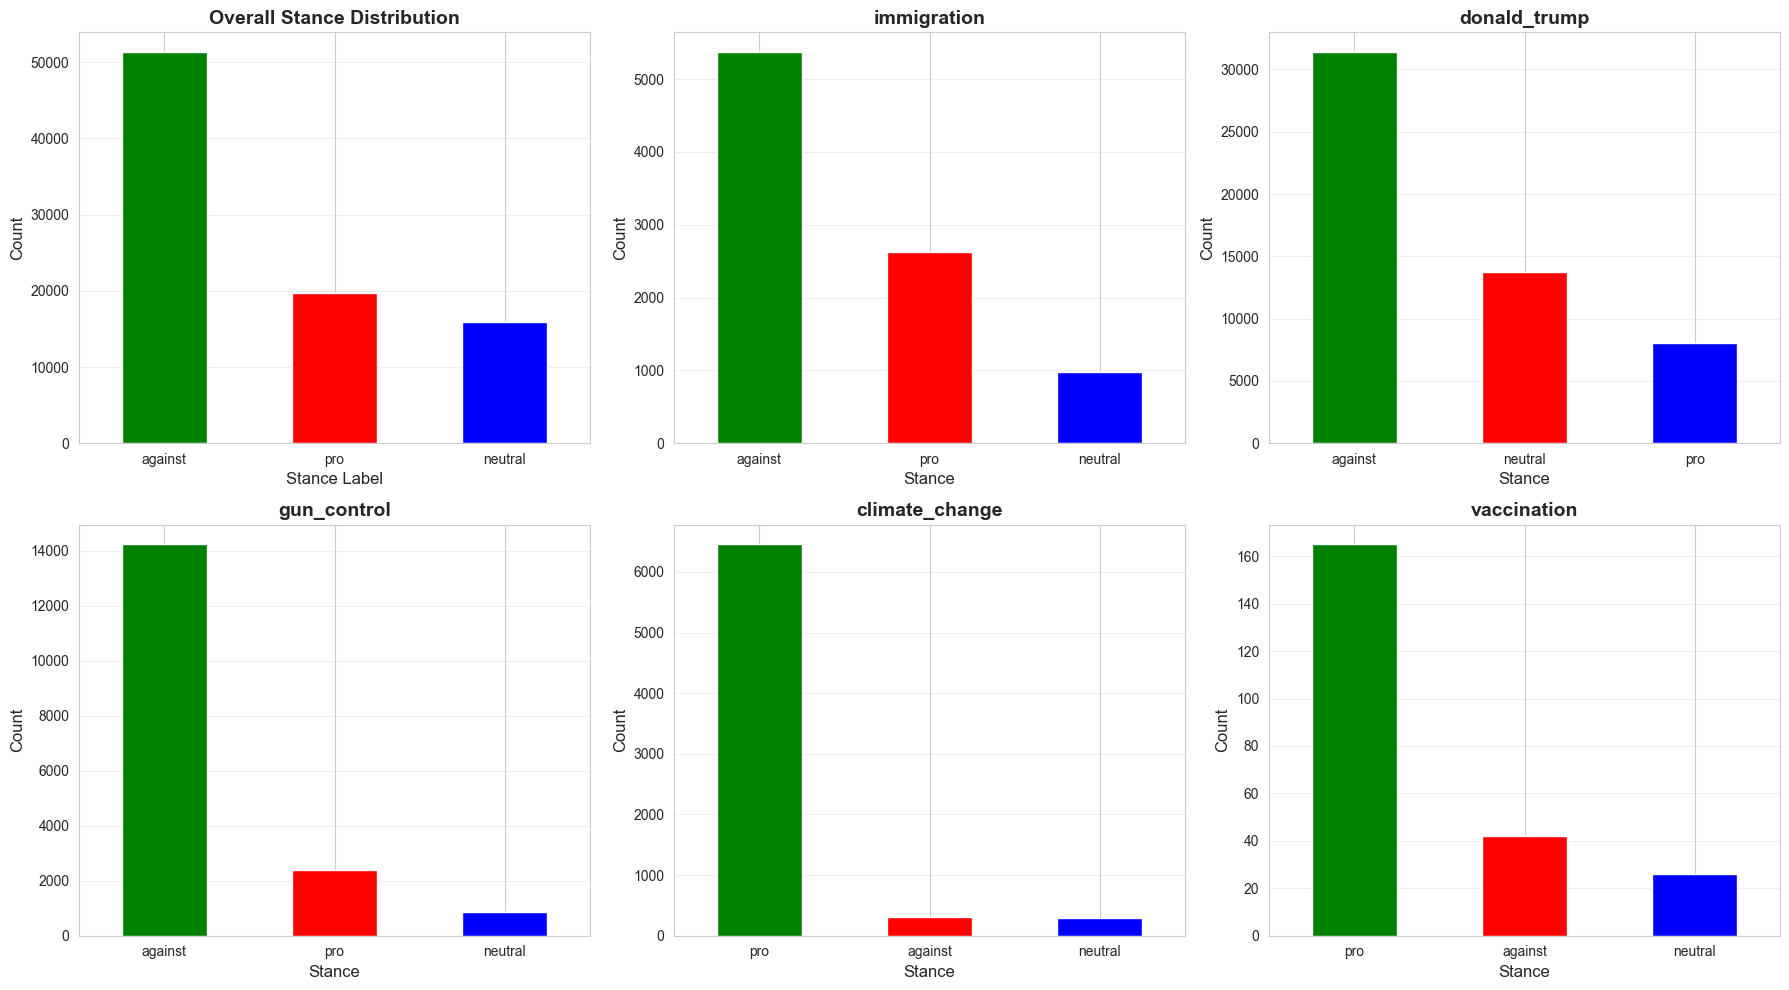

✓ Saved visualization: stance_distribution_full_corpus.png


In [42]:
# Visualize stance distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Overall distribution
ax = axes[0]
df_all_comments['stance_label'].value_counts().plot(kind='bar', ax=ax, color=['green', 'red', 'blue'])
ax.set_title('Overall Stance Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Stance Label', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.grid(axis='y', alpha=0.3)

# Per topic distributions
for idx, topic_id in enumerate(df_all_comments['thread_topic'].unique(), 1):
    ax = axes[idx]
    topic_data = df_all_comments[df_all_comments['thread_topic'] == topic_id]
    topic_data['stance_label'].value_counts().plot(kind='bar', ax=ax, color=['green', 'red', 'blue'])
    ax.set_title(f'{topic_id}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Stance', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(stance_path / 'stance_distribution_full_corpus.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: stance_distribution_full_corpus.png")


Confidence statistics:
count    86974.000000
mean         0.933945
std          0.121824
min          0.345514
25%          0.939293
50%          0.994533
75%          0.998641
max          0.999514
Name: stance_confidence, dtype: float64


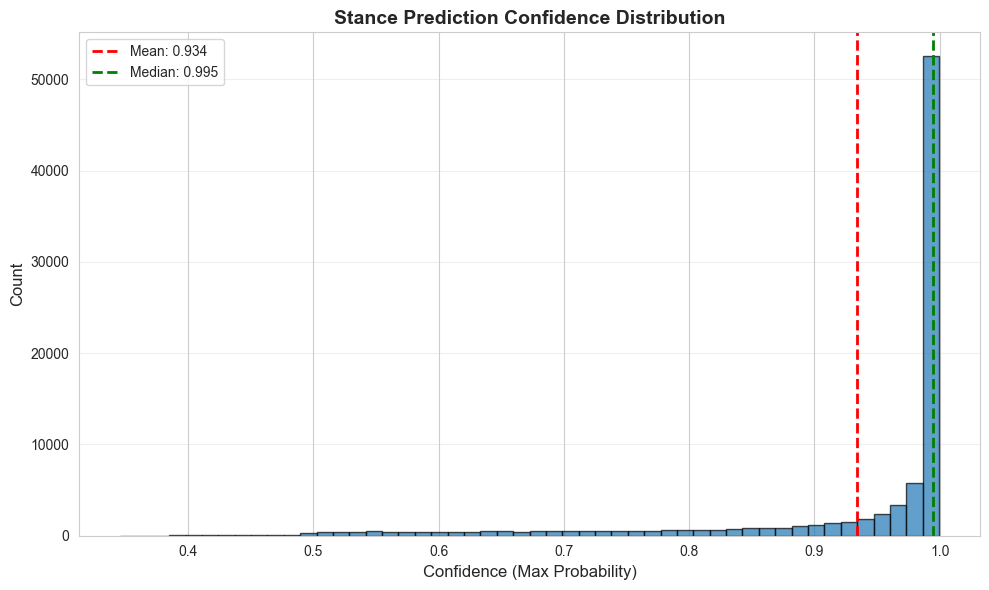

✓ Saved visualization: stance_confidence_distribution.png


In [43]:
# Confidence analysis
print("\nConfidence statistics:")
print(df_all_comments['stance_confidence'].describe())

# Plot confidence distribution
plt.figure(figsize=(10, 6))
plt.hist(df_all_comments['stance_confidence'], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(df_all_comments['stance_confidence'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_all_comments["stance_confidence"].mean():.3f}')
plt.axvline(df_all_comments['stance_confidence'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_all_comments["stance_confidence"].median():.3f}')
plt.title('Stance Prediction Confidence Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Confidence (Max Probability)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(stance_path / 'stance_confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: stance_confidence_distribution.png")

In [44]:
# Save comments with stance predictions
output_file = stance_path / 'comments_with_stance.parquet'
write_parquet(df_all_comments, output_file)

print(f"\n✓ Saved comments with stance predictions: {output_file}")
print(f"  {len(df_all_comments):,} comments")
print(f"  {df_all_comments.memory_usage(deep=True).sum() / 1e6:.1f} MB")

✓ Wrote 86,974 rows to comments_with_stance.parquet (23.2 MB)

✓ Saved comments with stance predictions: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/03_stance/reddit/comments_with_stance.parquet
  86,974 comments
  69.2 MB


## 7. Summary

Final summary of stance detection model and predictions.

In [45]:
# Print final summary
print("\n" + "="*80)
print("STANCE DETECTION COMPLETE")
print("="*80)

print(f"\n📊 MODEL PERFORMANCE:")
print(f"  Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"  F1 Score (Macro): {test_results['eval_f1_macro']:.4f}")
print(f"  F1 Score (Weighted): {test_results['eval_f1_weighted']:.4f}")

print(f"\n📈 CORPUS STATISTICS:")
print(f"  Total comments with stance: {len(df_all_comments):,}")
print(f"  Mean confidence: {df_all_comments['stance_confidence'].mean():.3f}")
print(f"  Median confidence: {df_all_comments['stance_confidence'].median():.3f}")

print(f"\n✅ OUTPUTS CREATED:")
print(f"  Model: {model_output_path / 'final_model'}")
print(f"  Predictions: {output_file}")
print(f"  Evaluation: {eval_file}")
print(f"  Visualizations: {stance_path}")

print("\n" + "="*80)
print("⚠️  IMPORTANT LIMITATIONS")
print("="*80)

print("\n🚨 CURRENT MODEL HAS SIGNIFICANT LIMITATIONS:")
print(f"   • Overall F1 ~{test_results['eval_f1_macro']:.2f} (target: >0.60 for final thesis)")
print("   • donald_trump topic performing poorly (F1 ~0.22)")
print("   • Small test set (9-11 examples per topic)")
print("\n📋 STATUS: Acceptable for PIPELINE VALIDATION only")
print("   • Testing methodology end-to-end")
print("   • Not final thesis results")
print("\n❗ REQUIRED FOR FINAL THESIS:")
print("   • Annotate 500-1000 total examples (2x-4x current)")
print("   • Focus on donald_trump, immigration, gun_control")
print("   • Target F1 > 0.60 across all topics")
print("   • Re-train model before final analysis")
print("\n⚠️  Downstream polarization metrics will have elevated noise")
print("   Document these limitations in methodology section")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)

print("\n1. REVIEW MODEL PERFORMANCE:")
print("   - Check confusion matrix for misclassifications")
print("   - Review per-topic performance")
print("   - Examine low-confidence predictions")

print("\n2. VALIDATE PREDICTIONS:")
print("   - Sample random predictions and verify quality")
print("   - Check stance distribution makes sense per topic")

print("\n3. PROCEED TO NOTEBOOK 17 (Pipeline Validation):")
print("   - Calculate polarization metrics using stance labels")
print("   - Analyze temporal trends in stance distribution")
print("   - Test forecasting approach (RQ3-4)")
print("   ⚠️  Remember: Results are exploratory, not final findings")

print("\n4. FOR FINAL THESIS:")
print("   - Return to improve stance detection model")
print("   - Re-run entire pipeline with improved model")
print("   - Document limitations and improvements in methodology")

print("\n" + "="*80)


STANCE DETECTION COMPLETE

📊 MODEL PERFORMANCE:


NameError: name 'test_results' is not defined